<a href="https://colab.research.google.com/github/mathewsrc/machine-learning-monitoring-with-evidently/blob/main/evidently_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyspark==3.5.0
!pip install -q duckdb==0.8
!pip install -q prefect
!pip install -q mlflow==2.8.1
!pip install -q evidently==0.4.9
!pip install -q soda-core-duckdb==3.0.45

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.7 MB/s eta 

In [2]:
import certifi
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import urllib3
from urllib3 import request
from unicodedata import normalize
from datetime import timedelta
import asyncio
import os

import duckdb

from prefect import task, flow

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (when, col, to_date, unix_timestamp,
                                   to_timestamp, from_utc_timestamp, year, month, day, dayofweek,
                                   regexp_like)
from pyspark.sql.types import (StructType, StructField, StringType,
                               IntegerType, FloatType, TimestampType, BooleanType)

# Pyspark Machine Learning
from pyspark.ml.feature import VectorAssembler, Imputer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# MLflow
import mlflow
import mlflow.spark
from mlflow import MlflowClient


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
!git clone https://github.com/mathewsrc/machine-learning-monitoring-with-evidently.git

Cloning into 'machine-learning-monitoring-with-evidently'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 35 (delta 9), reused 8 (delta 1), pack-reused 0
Receiving objects: 100% (35/35), 1.05 MiB | 4.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [5]:
%cd /content/machine-learning-monitoring-with-evidently
%ls

/content/machine-learning-monitoring-with-evidently
evidently_capstone.ipynb  LICENSE  README.md  soda/


## **Supplier Contracts: Extract, Transform, Load from API**

In [ ]:
#!mkdir soda
#!mkdir soda/checks
#!touch soda/checks/sources/raw_check.yml
#!touch soda/checks/staging/transfom_check.yml

touch: cannot touch 'soda/checks/sources/raw_check.yml': No such file or directory
touch: cannot touch 'soda/checks/staging/transfom_check.yml': No such file or directory


In [6]:
#%%writefile soda/check_function.py
def check(scan_name, duckdb_conn, data_source, checks_subpath=None):
    from soda.scan import Scan

    print('Running Soda Scan ...')
    checks_path = f'soda/checks'

    if checks_subpath:
        checks_path += f'/{checks_subpath}'

    scan = Scan()
    scan.set_verbose()
    scan.add_duckdb_connection(duckdb_conn)
    scan.set_data_source_name(data_source)
    scan.add_sodacl_yaml_files(checks_path)
    scan.set_scan_definition_name(scan_name)
    result = scan.execute()
    print(scan.get_logs_text())

    if result != 0:
        raise ValueError('Soda Scan failed')

    return result

In [7]:
spark = SparkSession.builder.appName("spark").getOrCreate()
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [17]:
@task(name="Extract Supplier Contract API data",
      description="Get API data from URL and read it as Spark DataFrame" ,
      tags=['supplier','vendor','contract'],
      cache_expiration=timedelta(days=1),
      retries=3,
      retry_delay_seconds=5)
def extract():

  if not os.path.exists("supplier.db"):
    print("Database not founded donwload data from API")
    # get api data from url
    #url = 'https://data.cityofnewyork.us/resource/h9gi-nx95.json?$limit=500'
    url = 'https://data.sfgov.org/resource/cqi5-hm2d.json?$limit=50000'

    # Check if API is available to retrive the
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())
    apt_status = http.request('GET', url).status
    print(apt_status)
    if apt_status == 200:
        # Sometimes we get certificate error . We shoul never silence this error as this may cause a securirty threat.
        # Create a Pool manager that can be used to read the API response
        data = json.loads(http.request('GET', url).data.decode('utf-8'))
        df_api = pd.json_normalize(data)
        with duckdb.connect("supplier.db") as conn:
          conn.sql("""CREATE OR REPLACE TABLE supplier_raw_table AS
                          SELECT * FROM df_api""")
          conn.sql("SELECT COUNT(*) FROM supplier_raw_table").show()
    else:
        raise Exception('Error to extract data from API!')
  else:
    print("Database founded API not called")
    with duckdb.connect("supplier.db") as conn:
      conn.sql("SELECT COUNT(*) FROM supplier_raw_table").show()


In [9]:
@task(name="Extract Supplier Contract API data",
      description="Get API data from URL and read it as Spark DataFrame" ,
      tags=['supplier','vendor','contract'],
      cache_expiration=timedelta(days=1),
      retries=3,
      retry_delay_seconds=5)
def check_raw():
  with duckdb.connect("supplier.db") as conn:
    check(scan_name="raw_check", duckdb_conn=conn, data_source="duckdb", checks_subpath="sources")

In [58]:
@task(name="Extract Supplier Contract API data",
      description="Get API data from URL and read it as Spark DataFrame" ,
      tags=['supplier','vendor','contract'],
      cache_expiration=timedelta(days=1),
      retries=3,
      retry_delay_seconds=5)
def transform():

  with duckdb.connect("supplier.db") as conn:
    df_pandas = conn.sql("SELECT * FROM supplier_raw_table").df()

    df_spark = spark.createDataFrame(df_pandas)

    df_spark = (
        df_spark
          .withColumnRenamed("contract_no", "contract_number")
          .withColumnRenamed("consumed_amt", "purchase_orders_outstanding")
          .withColumnRenamed("agreed_amt", "contract_awarded_amount")
          .withColumnRenamed("pmt_amt", "payments_made")
          .withColumnRenamed("remaining_amt", "remaining_contract_award_amount")
          .withColumnRenamed("project_team_constituent", "supplier_type")
          .withColumnRenamed("project_team_supplier", "supplier_name")
          .withColumnRenamed("prime_contractor", "supplier_name_prime_contractor")
    )

    df_spark = df_spark.dropDuplicates(subset=['contract_number'])


    df_spark = df_spark.na.drop(subset=["contract_number"])

    df_spark = (
      df_spark
        .withColumn("purchase_orders_outstanding", col("purchase_orders_outstanding").cast("float"))
        .withColumn("contract_awarded_amount", col("contract_awarded_amount").cast("float"))
        .withColumn("payments_made", col("payments_made").cast("float"))
        .withColumn("remaining_contract_award_amount", col("remaining_contract_award_amount").cast("float"))
    )

    df_spark = df_spark.withColumn("start_date",
                              to_date((from_utc_timestamp('term_start_date', 'UTC'))))
    df_spark = df_spark.withColumn("end_date",
                                   to_date(from_utc_timestamp('term_end_date', 'UTC')))

    df_spark.createOrReplaceTempView("supplier_contracts")

    df_spark = spark.sql("""
          SELECT
              *,
              EXTRACT(DAY FROM start_date) AS start_day,
              EXTRACT(MONTH FROM start_date) AS start_month,
              EXTRACT(YEAR FROM start_date) AS start_year,
              EXTRACT(DAY FROM end_date) AS end_day,
              EXTRACT(MONTH FROM end_date) AS end_month,
              EXTRACT(YEAR FROM end_date) AS end_year
          FROM supplier_contracts
          WHERE start_date IS NOT NULL
                AND end_date IS NOT NULL
          """)


    df_spark.createOrReplaceTempView("supplier_contracts")

    df_spark = spark.sql("""
              SELECT *,
                  CASE WHEN sole_source_flg IS NULL THEN 1
                  ELSE 0 END AS is_sole_source
              FROM supplier_contracts
                """)

    df_spark = df_spark.drop("sole_source_flg")

    df_spark.createOrReplaceTempView("supplier_contracts")

    df_spark = spark.sql("""
                         SELECT *,
                            CASE WHEN non_profit IS NULL THEN 1
                            ELSE 0 END AS is_non_profit
                         FROM supplier_contracts
                         """)

    df_spark = df_spark.withColumn("has_outstanding_orders",
                                   when(
                                      col('purchase_orders_outstanding') > 0,
                                      1).otherwise(0))

    df_spark = df_spark.filter("payments_made >= 0")
    df_spark = df_spark.filter("payments_made <= contract_awarded_amount")
    df_spark = df_spark.filter("remaining_contract_award_amount >= 0")
    df_spark = df_spark.filter("contract_awarded_amount >= 0")
    df_spark = df_spark.filter("remaining_contract_award_amount <= contract_awarded_amount")
    df_spark = df_spark.filter((col("payments_made")
    + col("remaining_contract_award_amount")) <= col("contract_awarded_amount"))
    df_spark = df_spark.filter("purchase_orders_outstanding >= 0")

    df_pandas = df_spark.toPandas()

    conn.sql("""CREATE OR REPLACE TABLE supplier_transformed_table AS
                    SELECT * FROM df_pandas""")
    return df_spark

In [11]:
@task(name="Extract Supplier Contract API data",
      description="Get API data from URL and read it as Spark DataFrame" ,
      tags=['supplier','vendor','contract'],
      cache_expiration=timedelta(days=1),
      retries=3,
      retry_delay_seconds=5)
def check_staging():
  with duckdb.connect("supplier.db") as conn:
    check(scan_name="transformation_check", duckdb_conn=conn, data_source="duckdb", checks_subpath="staging")

In [12]:
@task(name="Extract Supplier Contract API data",
      description="Get API data from URL and read it as Spark DataFrame" ,
      tags=['supplier','vendor','contract'],
      cache_expiration=timedelta(days=1),
      retries=3,
      retry_delay_seconds=5)
def load(df_spark):
  with duckdb.connect("supplier.db") as conn:
    df_pandas = df_spark.toPandas()
    conn.sql("CREATE OR REPLACE TABLE supplier_transformed_table AS SELECT * FROM df_pandas")

In [13]:
@flow(name="ETL Supplier Contract API", log_prints=True)
def etl():
  extract()
  check_raw()
  df_spark = transform()
  check_staging()
  load(df_spark)

In [59]:
etl()

15:51:49.646 | INFO    | alembic.runtime.migration - Context impl SQLiteImpl.

15:51:49.649 | INFO    | alembic.runtime.migration - Will assume non-transactional DDL.

15:51:49.814 | INFO    | prefect.engine - Created flow run 'cyan-guppy' for flow 'ETL Supplier Contract API'

15:51:49.939 | INFO    | Flow run 'cyan-guppy' - Created task run 'Extract Supplier Contract API data-0' for task 'Extract Supplier Contract API data'

15:51:49.943 | INFO    | Flow run 'cyan-guppy' - Executing 'Extract Supplier Contract API data-0' immediately...

15:51:50.612 | INFO    | Task run 'Extract Supplier Contract API data-0' - Database founded API not called

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│        38068 │
└──────────────┘



15:51:50.696 | INFO    | Task run 'Extract Supplier Contract API data-0' - Finished in state Completed()

15:51:50.751 | INFO    | Flow run 'cyan-guppy' - Created task run 'Extract Supplier Contract API data-0' for task 'Extract Supplier Contract API data'

15:51:50.755 | INFO    | Flow run 'cyan-guppy' - Executing 'Extract Supplier Contract API data-0' immediately...

15:51:50.851 | INFO    | Task run 'Extract Supplier Contract API data-0' - Running Soda Scan ...

15:51:50.918 | INFO    | Task run 'Extract Supplier Contract API data-0' - INFO   | Soda Core 3.0.45
DEBUG  | Reading SodaCL file "soda/checks/sources/raw_check.yml"
DEBUG  | Scan execution starts
DEBUG  | Query duckdb.supplier_raw_table.aggregation[0]:
SELECT 
  COUNT(*) 
FROM supplier_raw_table
DEBUG  | Query duckdb.supplier_raw_table.schema[supplier_raw_table]:
SELECT column_name, lower(data_type) as data_type, is_nullable 
FROM information_schema.columns 
WHERE (table_name) = 'supplier_raw_table'
ORDER BY ORDINAL_POSITION
INFO   | Scan summary:
DEBUG  | 2/2 queries OK
DEBUG  |   duckdb.supplier_raw_table.aggregation[0] [OK] 0:00:00.000974
DEBUG  |   duckdb.supplier_raw_table.schema[supplier_raw_table] [OK] 0:00:00.032312
INFO   | 2/2 checks PASSED: 
INFO   |     supplier_raw_table in duckdb
INFO   |       Check the number of rows [soda/checks/sources/raw_check.yml] [PASSED]
INFO   |         check_value: 38068
INFO   |       Confirm that required columns are present [soda/checks/sources/raw_check.yml] [PASSED]
INFO   |         schema_measured = [contract_title varchar, term_start_date varchar, term_end_date varchar, contract_type varchar, purchasing_authority varchar, department_code varchar, department varchar, prime_contractor varchar, project_team_supplier varchar, project_team_lbe_status varchar, project_team_constituent varchar, scope_of_work varchar, agreed_amt varchar, consumed_amt varchar, pmt_amt varchar, remaining_amt varchar, contract_no varchar, non_profit varchar, sole_source_flg varchar]
INFO   | All is good. No failures. No warnings. No errors.

15:51:50.978 | INFO    | Task run 'Extract Supplier Contract API data-0' - Finished in state Completed()

15:51:51.031 | INFO    | Flow run 'cyan-guppy' - Created task run 'Extract Supplier Contract API data-0' for task 'Extract Supplier Contract API data'

15:51:51.034 | INFO    | Flow run 'cyan-guppy' - Executing 'Extract Supplier Contract API data-0' immediately...

15:52:05.253 | INFO    | Task run 'Extract Supplier Contract API data-0' - Finished in state Completed()

15:52:05.332 | INFO    | Flow run 'cyan-guppy' - Created task run 'Extract Supplier Contract API data-0' for task 'Extract Supplier Contract API data'

15:52:05.342 | INFO    | Flow run 'cyan-guppy' - Executing 'Extract Supplier Contract API data-0' immediately...

15:52:05.447 | INFO    | Task run 'Extract Supplier Contract API data-0' - Running Soda Scan ...

15:52:05.755 | INFO    | Task run 'Extract Supplier Contract API data-0' - INFO   | Soda Core 3.0.45
DEBUG  | Reading SodaCL file "soda/checks/staging/transfom_check.yml"
DEBUG  | Scan execution starts
DEBUG  | Query duckdb.supplier_transformed_table.aggregation[0]:
SELECT 
  COUNT(*),
  COUNT(CASE WHEN contract_number IS NULL THEN 1 END),
  COUNT(CASE WHEN NOT (has_outstanding_orders IS NULL) AND NOT (has_outstanding_orders IN (True,False)) THEN 1 END),
  COUNT(CASE WHEN NOT (is_sole_source IS NULL) AND NOT (is_sole_source IN (True,False)) THEN 1 END),
  COUNT(CASE WHEN NOT (end_month IS NULL) AND NOT (end_month >= 1.0 AND end_month <= 12.0) THEN 1 END),
  COUNT(CASE WHEN NOT (start_month IS NULL) AND NOT (start_month >= 1.0 AND start_month <= 12.0) THEN 1 END),
  COUNT(CASE WHEN NOT (contract_awarded_amount IS NULL) AND NOT (contract_awarded_amount >= 0.0) THEN 1 END),
  COUNT(CASE WHEN NOT (purchase_orders_outstanding IS NULL) AND NOT (purchase_orders_outstanding >= 0.0) THEN 1 END),
  COUNT(CASE WHEN NOT (payments_made IS NULL) AND NOT (payments_made >= 0.0) THEN 1 END),
  COUNT(CASE WHEN NOT (remaining_contract_award_amount IS NULL) AND NOT (remaining_contract_award_amount >= 0.0) THEN 1 END),
  COUNT(CASE WHEN NOT (start_date IS NULL) AND NOT (REGEXP_MATCHES(start_date, '^ *(19|20)?\d\d[-\./]([1-9]|0[1-9]|1[012])[-\./]([1-9]|[012][0-9]|3[01]) *$')) THEN 1 END),
  COUNT(CASE WHEN NOT (end_date IS NULL) AND NOT (REGEXP_MATCHES(end_date, '^ *(19|20)?\d\d[-\./]([1-9]|0[1-9]|1[012])[-\./]([1-9]|[012][0-9]|3[01]) *$')) THEN 1 END)
FROM supplier_transformed_table
DEBUG  | Query duckdb.end_date.failed_rows[invalid_count]:
SELECT * FROM supplier_transformed_table 
 WHERE NOT (end_date IS NULL) AND NOT (REGEXP_MATCHES(end_date, '^ *(19|20)?\d\d[-\./]([1-9]|0[1-9]|1[012])[-\./]([1-9]|[012][0-9]|3[01]) *$'))
 LIMIT 100
INFO   | Using DefaultSampler
DEBUG  | Query duckdb.supplier_transformed_table.contract_number.duplicate_count:

WITH frequencies AS (
    SELECT COUNT(*) AS frequency
    FROM supplier_transformed_table
    WHERE contract_number IS NOT NULL
    GROUP BY contract_number)
SELECT count(*)
FROM frequencies
WHERE frequency > 1
DEBUG  | Query duckdb.supplier_transformed_table.duplicate_count[contract_number].failed_rows.aggregated:

WITH frequencies AS (
    SELECT contract_number, COUNT(*) AS frequency
    FROM supplier_transformed_table
    WHERE contract_number IS NOT NULL
    GROUP BY contract_number)
SELECT *
FROM frequencies
WHERE frequency > 1
ORDER BY frequency DESC
LIMIT 100
DEBUG  | Query duckdb.user_defined_query[exceeds_limit = 0]:
SELECT 
  SUM(CASE 
    WHEN payments_made + remaining_contract_award_amount > contract_awarded_amount THEN 1 
    ELSE 0 
  END) AS exceeds_limit
FROM supplier_transformed_table
DEBUG  | Query duckdb.user_defined_query[exceeds_date = 0]:
SELECT 
  SUM(CASE  
    WHEN start_date > end_date THEN 1
    ELSE 0
  END) AS exceeds_date
FROM supplier_transformed_table
DEBUG  | Query duckdb.supplier_transformed_table.schema[supplier_transformed_table]:
SELECT column_name, lower(data_type) as data_type, is_nullable 
FROM information_schema.columns 
WHERE (table_name) = 'supplier_transformed_table'
ORDER BY ORDINAL_POSITION
INFO   | Scan summary:
DEBUG  | 7/7 queries OK
DEBUG  |   duckdb.supplier_transformed_table.aggregation[0] [OK] 0:00:00.025405
DEBUG  |   duckdb.end_date.failed_rows[invalid_count] [OK] 0:00:00.033974
DEBUG  |   duckdb.supplier_transformed_table.contract_number.duplicate_count [OK] 0:00:00.018007
DEBUG  |   duckdb.supplier_transformed_table.duplicate_count[contract_number].failed_rows.aggregated [OK] 0:00:00.017174
DEBUG  |   duckdb.user_defined_query[exceeds_limit = 0] [OK] 0:00:00.001667
DEBUG  |   duckdb.user_defined_query[exceeds_date = 0] [OK] 0:00:00.001005
DEBUG  |   duckdb.supplier_transformed_table.schema[supplier_transformed_table] [OK] 0:00:00.052239
INFO   | 16/16 checks PASSED: 
INFO   |     supplier_transformed_table in duckdb
INFO   |       Check the number o

15:52:05.845 | INFO    | Task run 'Extract Supplier Contract API data-0' - Finished in state Completed()

15:52:05.891 | INFO    | Flow run 'cyan-guppy' - Created task run 'Extract Supplier Contract API data-0' for task 'Extract Supplier Contract API data'

15:52:05.894 | INFO    | Flow run 'cyan-guppy' - Executing 'Extract Supplier Contract API data-0' immediately...

15:52:08.038 | INFO    | Task run 'Extract Supplier Contract API data-0' - Finished in state Completed()

15:52:08.171 | INFO    | Flow run 'cyan-guppy' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `DataFrame`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`'))]

In [202]:
with duckdb.connect("supplier.db") as conn:
 print(conn.sql("DESCRIBE supplier_transformed_table"))
 conn.sql("SELECT DISTINCT(contract_type) FROM supplier_transformed_table").show()

┌────────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬───────┐
│          column_name           │ column_type │  null   │   key   │ default │ extra │
│            varchar             │   varchar   │ varchar │ varchar │ varchar │ int32 │
├────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼───────┤
│ contract_title                 │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ term_start_date                │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ term_end_date                  │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ contract_type                  │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ purchasing_authority           │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ department_code                │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ department                     │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ supplier_name_prime_contractor │ VARCHAR 

## **Visualizations**

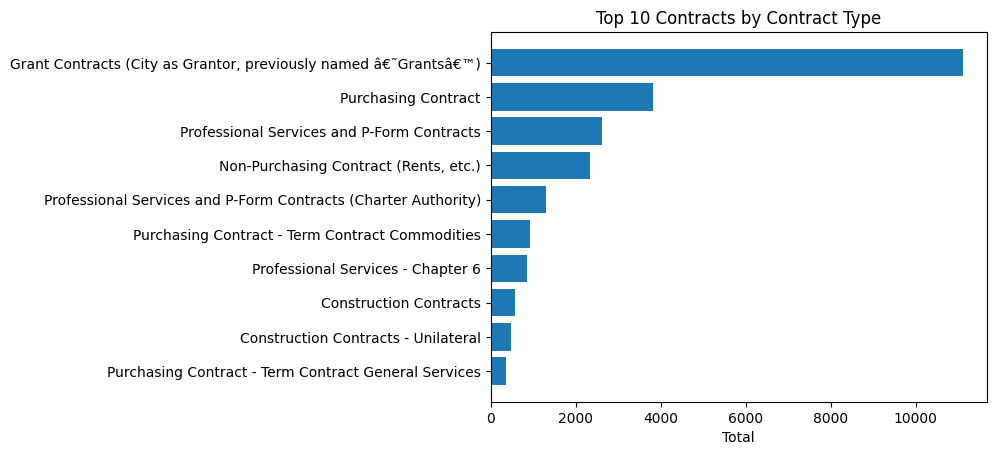

In [281]:
with duckdb.connect("supplier.db") as conn:
  df_pl = conn.sql(
      """
      SELECT
        contract_type,
        COUNT(contract_type) AS total
      FROM supplier_transformed_table
      WHERE contract_type IS NOT NULL
      GROUP BY contract_type
      ORDER BY total DESC
      LIMIT 10
      """
      ).pl().sort("total")


  plt.barh(df_pl['contract_type'],
          df_pl['total'])
  plt.title("Top 10 Contracts by Contract Type")
  plt.xlabel("Total")
  plt.show()

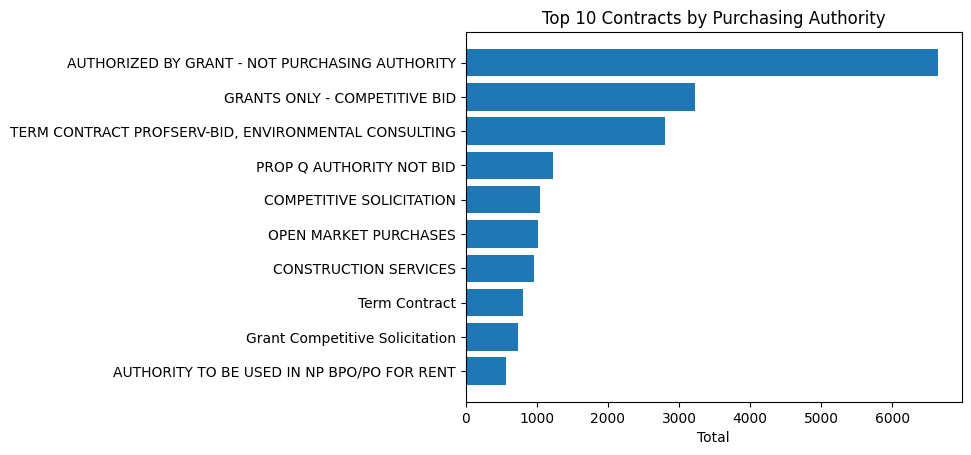

In [282]:
with duckdb.connect("supplier.db") as conn:
  df_pl = conn.sql(
      """
      SELECT
        purchasing_authority,
        COUNT(purchasing_authority) AS total
      FROM supplier_transformed_table
      WHERE purchasing_authority IS NOT NULL
      GROUP BY purchasing_authority
      ORDER BY total DESC
      LIMIT 10
      """
      ).pl().sort("total")


  plt.barh(df_pl['purchasing_authority'],
          df_pl['total'])
  plt.title("Top 10 Contracts by Purchasing Authority")
  plt.xlabel("Total")
  plt.show()

## **ML monitoring with Evidentlyai**

In [61]:
from evidently.spark.engine import SparkEngine

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DataDriftTable, DatasetDriftMetric
from evidently.metric_preset import DataDriftPreset

from evidently.test_suite import TestSuite
from evidently.tests import TestColumnDrift, TestShareOfDriftedColumns, TestNumberOfDriftedColumns
from evidently.test_preset import DataDriftTestPreset

In [24]:
with duckdb.connect("supplier.db") as conn:
  df_pandas = conn.sql("SELECT * FROM supplier_transformed_table").df()

  df_spark = spark.createDataFrame(df_pandas)
# Simulate current and reference data using randomSplit
current_data, reference_data = df_spark.randomSplit(weights=[0.5,0.5], seed=200)

In [25]:
column_mapping = ColumnMapping()

#column_mapping.prediction = "prediction"
#column_mapping.target = "target"
#column_mapping.target_names = ['churn', 'not_churn']
column_mapping.id = "contract_number"

column_mapping.datetime_features = ['start_date',
                                    'end_date',
                                    'term_start_date',
                                    'term_end_date',]

column_mapping.text_features = ['contract_title',
                                'supplier_name',
                                'supplier_name_prime_contractor',
                                'department',
                                'purchasing_authority',]

column_mapping.categorical_features= ['contract_type',
                                      'department_code',
                                      'project_team_lbe_status',
                                      'scope_of_work',
                                      'non_profit',
                                      'is_sole_source',
                                      'has_outstanding_orders',]

column_mapping.numerical_features = ['contract_awarded_amount',
                                     'purchase_orders_outstanding',
                                     'payments_made',
                                     'remaining_contract_award_amount',
                                     'start_day', 'start_month',
                                     'start_year', 'end_day',
                                     'end_month', 'end_year',]

In [26]:
def eval_drift(reference, production, column_mapping):

    data_drift_report = Report(metrics=[DataDriftPreset()])
    data_drift_report.run(reference_data=reference, current_data=production, column_mapping=column_mapping)
    report = data_drift_report.as_dict()

    drifts = []

    for feature in column_mapping.numerical_features + column_mapping.categorical_features:
        drifts.append((feature, report["metrics"][1]["result"]["drift_by_columns"][feature]["drift_score"]))

    return drifts

In [145]:
with duckdb.connect("supplier.db") as conn:
  start_date = conn.sql("""SELECT MIN(start_date)
              FROM supplier_transformed_table
              """).fetchone()
  start_date_0 = start_date[0].strftime("%Y-%m-%d %H:%M:%S")

  end_date = conn.sql("""SELECT MAX(start_date) - INTERVAL 3 YEAR AS end_date
              FROM supplier_transformed_table
              """).fetchone()
  end_date_0 = end_date[0].strftime("%Y-%m-%d %H:%M:%S")

print(start_date_0)
print(end_date_0)


1991-12-03 00:00:00
2021-01-01 00:00:00


In [262]:
with duckdb.connect("supplier.db") as conn:
 experiment_batches_sql = conn.sql(
    f"""
    WITH numbered_rows AS (
        SELECT
            start_date,
            EXTRACT(MONTH FROM start_date) AS month,
            RANK() OVER (ORDER BY month) AS rank
        FROM
            supplier_transformed_table
        WHERE start_date > (SELECT
            DATE_ADD(MAX(start_date) - INTERVAL 3 YEAR, INTERVAL 1 YEAR) AS max_date
        FROM supplier_transformed_table)
    )

    SELECT
      MIN(start_date),
      DATE_ADD(MIN(start_date), INTERVAL 1 MONTH) AS end_date,
    FROM
      numbered_rows
    GROUP BY
      rank;
   """
  )
 print(experiment_batches_sql.show())
 experiment_batches=[(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")) for start, end in experiment_batches_sql.fetchall() ]


┌─────────────────┬────────────┐
│ min(start_date) │  end_date  │
│      date       │    date    │
├─────────────────┼────────────┤
│ 2022-01-03      │ 2022-02-03 │
│ 2022-02-01      │ 2022-03-01 │
│ 2022-03-01      │ 2022-04-01 │
│ 2022-04-01      │ 2022-05-01 │
│ 2022-05-01      │ 2022-06-01 │
│ 2022-06-01      │ 2022-07-01 │
│ 2022-07-01      │ 2022-08-01 │
│ 2022-08-01      │ 2022-09-01 │
│ 2022-09-01      │ 2022-10-01 │
│ 2022-10-01      │ 2022-11-01 │
│ 2022-11-01      │ 2022-12-01 │
│ 2022-12-01      │ 2023-01-01 │
├─────────────────┴────────────┤
│ 12 rows            2 columns │
└──────────────────────────────┘

None


In [263]:
with duckdb.connect("supplier.db") as conn:
  df_pandas = conn.sql("SELECT * FROM supplier_transformed_table").df()
  df_spark = spark.createDataFrame(df_pandas)

  reference_data = df_spark.filter((col("start_date") >= start_date_0) & (col("start_date") <= end_date_0))
print(reference_data.agg({"start_date": "max"}).show())
print(reference_data.agg({"start_date": "min"}).show())

+-------------------+
|    max(start_date)|
+-------------------+
|2021-01-01 00:00:00|
+-------------------+

None
+-------------------+
|    min(start_date)|
+-------------------+
|1991-12-03 00:00:00|
+-------------------+

None


In [264]:
reference_data.show(n=3)

+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------------------------+--------------------+-----------------------+----------------+--------------------+-----------------------+---------------------------+-------------+-------------------------------+---------------+----------+-------------------+-------------------+---------+-----------+----------+-------+---------+--------+--------------+-------------+----------------------+
|      contract_title|     term_start_date|       term_end_date|       contract_type|purchasing_authority|department_code|          department|supplier_name_prime_contractor|       supplier_name|project_team_lbe_status|   supplier_type|       scope_of_work|contract_awarded_amount|purchase_orders_outstanding|payments_made|remaining_contract_award_amount|contract_number|non_profit|         start_date|           end_date|start_day|start_month|start_year|end_day|en

In [265]:
with duckdb.connect("supplier.db") as conn:
  conn.sql(
      """
      CREATE OR REPLACE TABLE reference_table AS
      SELECT *
      FROM supplier_transformed_table
      WHERE start_year <= 2021
      """)

  conn.sql(
      """
      CREATE OR REPLACE TABLE current_table AS
      SELECT *
      FROM supplier_transformed_table
      WHERE start_year >= 2022;
      """)

In [266]:
with duckdb.connect("supplier.db") as conn:
  reference_tbl= conn.sql("SELECT * FROM reference_table")
  reference_tbl.show()
  reference_data = spark.createDataFrame(reference_tbl.df())

┌──────────────────────┬──────────────────────┬───┬────────────────┬───────────────┬──────────────────────┐
│    contract_title    │   term_start_date    │ … │ is_sole_source │ is_non_profit │ has_outstanding_or…  │
│       varchar        │       varchar        │   │     int32      │     int32     │        int32         │
├──────────────────────┼──────────────────────┼───┼────────────────┼───────────────┼──────────────────────┤
│ CHF-GA-Mission YMC…  │ 2018-07-01T00:00:0…  │ … │              1 │             0 │                    1 │
│ ADMINISTRATIVE CHA…  │ 2016-08-03T00:00:0…  │ … │              1 │             1 │                    0 │
│ CLP - RESOURCE ADE…  │ 2017-02-24T00:00:0…  │ … │              1 │             1 │                    0 │
│ CLP - RESOURCE ADE…  │ 2017-02-24T00:00:0…  │ … │              1 │             1 │                    0 │
│ ASSOCIATION OF BAY…  │ 2007-03-23T00:00:0…  │ … │              0 │             1 │                    0 │
│ ENGINEERING POOL     │ 200

In [267]:
with duckdb.connect("supplier.db") as conn:
  current_tbl = conn.sql("SELECT * FROM current_table")
  current_tbl.show()
  current_data = spark.createDataFrame(current_tbl.df())

┌──────────────────────┬──────────────────────┬───┬────────────────┬───────────────┬──────────────────────┐
│    contract_title    │   term_start_date    │ … │ is_sole_source │ is_non_profit │ has_outstanding_or…  │
│       varchar        │       varchar        │   │     int32      │     int32     │        int32         │
├──────────────────────┼──────────────────────┼───┼────────────────┼───────────────┼──────────────────────┤
│ Parking at 255-12t…  │ 2022-07-01T00:00:0…  │ … │              1 │             1 │                    1 │
│ PW Bttr Mkt St       │ 2022-05-31T00:00:0…  │ … │              1 │             1 │                    1 │
│ PW Racial Equity C…  │ 2022-03-18T00:00:0…  │ … │              1 │             1 │                    1 │
│ License Agreement …  │ 2022-02-01T00:00:0…  │ … │              1 │             1 │                    0 │
│ PUC_CLP_2022 Local…  │ 2022-01-01T00:00:0…  │ … │              1 │             1 │                    0 │
│ DPH-Finger Prick D…  │ 202

In [268]:
with duckdb.connect("supplier.db") as conn:
  conn.sql("SELECT COUNT(*) AS total_reference FROM reference_table").show()
  conn.sql("SELECT COUNT(*) AS total_current FROM current_table").show()


┌─────────────────┐
│ total_reference │
│      int64      │
├─────────────────┤
│           18920 │
└─────────────────┘

┌───────────────┐
│ total_current │
│     int64     │
├───────────────┤
│          5472 │
└───────────────┘



In [269]:
def train_and_evaluate(model, model_name):

  for k, test_dates in enumerate(experiment_batches):

    print(f"Batch: {k}")
    print(f"Test dates: {test_dates}")

    label_col = 'is_sole_source'
    numeric_cols = ['contract_awarded_amount',
                    'purchase_orders_outstanding',
                    'payments_made',
                    'remaining_contract_award_amount',]

    categorical_cols = ['contract_type',
                        'department_code',
                        'project_team_lbe_status',
                        'scope_of_work',
                        'is_non_profit',
                        'is_sole_source',
                        'has_outstanding_orders',]

    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded") for col in categorical_cols]

    # Assemble Features
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features") #numeric_cols + [f"{col}_encoded" for col in categorical_cols]

    # Impute Missing Values for Numeric and Categorical Columns
    imputer_numeric = Imputer(strategy="mean", inputCols=numeric_cols,
                              outputCols=[f"{col}_imputed" for col in numeric_cols])
    imputer_categorical = Imputer(strategy="most_frequent", inputCols=[f"{col}_encoded" for col in categorical_cols], outputCols=[f"{col}_imputed" for col in categorical_cols])

    # Scaling Features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Random Forest Classifier
    rf = RandomForestClassifier(featuresCol="scaled_features", labelCol=label_col)

    # Create the Pipeline
    pipeline = Pipeline(stages=[assembler, imputer_numeric, scaler, rf])#indexers + encoders +

    # Fit the Pipeline on the Training Data
    pipeline_model = pipeline.fit(reference_data)

    predictions_reference = pipeline_model.transform(reference_data)

    current_dataa = current_data.filter(
            (col("start_date") >= test_dates[0]) & (col("start_date") <= test_dates[1]))

    print(f"Number of observations full dataset: {current_data.count()}")
    print(f"Number of observations: {current_dataa.count()}")

    predictions_current = pipeline_model.transform(current_dataa)

    evaluator = BinaryClassificationEvaluator(labelCol=label_col,
                                              rawPredictionCol="prediction",
                                              metricName="areaUnderROC")

    auc_reference = evaluator.evaluate(predictions_reference)
    print(f"{model_name} AUC (reference): {auc_reference}")

    auc_current = evaluator.evaluate(predictions_current)
    print(f"{model_name} AUC (current): {auc_current}")

    mlflow.set_experiment_tag("model", model_name)

    mlflow.log_metric(f"{model_name}_AUC_reference", auc_reference)
    mlflow.log_metric(f"{model_name}_AUC_current", auc_current)

    # mlflow.spark.log_model(pipeline_model,
    #                       artifact_path="spark-model",
    #                       registered_model_name=f"{model_name}_Model")


In [270]:
mlflow.set_tracking_uri("sqlite:///mlruns.db") # for local experiment, change to "http://127.0.0.1:5000" in vscode to access MLflow UI

EXPERIMENT_NAME = "supplier_contract_experiment"
mlflow.set_experiment(EXPERIMENT_NAME)

models = {
    #"Linear Regression": LinearRegression(),
    #"Random Forest Regressor": RandomForestRegressor(),
    #"GBT Regressor": GBTRegressor(),
    #"Logistic_Regression": LogisticRegression(),
    "Random_Forest_Classifier": RandomForestClassifier(),
    #"GBT_Classifier": GBTClassifier()

}

for model_name, model in models.items():
  with mlflow.start_run(run_name=model_name):
      print(f"Training and evaluating {model_name}")
      train_and_evaluate(model, model_name)



Training and evaluating Random_Forest_Classifier
Batch: 0
Test dates: ('2022-01-03', '2022-02-03')
Number of observations full dataset: 5472
Number of observations: 105
Random_Forest_Classifier AUC (reference): 0.5
Random_Forest_Classifier AUC (current): 0.5
Batch: 1
Test dates: ('2022-02-01', '2022-03-01')
Number of observations full dataset: 5472
Number of observations: 161
Random_Forest_Classifier AUC (reference): 0.5
Random_Forest_Classifier AUC (current): 0.5
Batch: 2
Test dates: ('2022-03-01', '2022-04-01')
Number of observations full dataset: 5472
Number of observations: 242
Random_Forest_Classifier AUC (reference): 0.5
Random_Forest_Classifier AUC (current): 0.5
Batch: 3
Test dates: ('2022-04-01', '2022-05-01')
Number of observations full dataset: 5472
Number of observations: 241
Random_Forest_Classifier AUC (reference): 0.5
Random_Forest_Classifier AUC (current): 0.5
Batch: 4
Test dates: ('2022-05-01', '2022-06-01')
Number of observations full dataset: 5472
Number of observati

In [ ]:
mlflow.search_runs(experiment_names=EXPERIMENT_NAME)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Random Forest Classifier_AUC,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.type
0,c08de055cbe4438d836358dc24300830,1,FINISHED,/content/machine-learning-monitoring-with-evid...,2023-11-28 22:12:36.953000+00:00,2023-11-28 22:13:23.967000+00:00,0.5,/usr/local/lib/python3.10/dist-packages/colab_...,"[{""run_id"": ""c08de055cbe4438d836358dc24300830""...",root,Random Forest Classifier,LOCAL
1,ae41eb9f63514dc7bc88a9604c5e8ca7,1,FINISHED,/content/machine-learning-monitoring-with-evid...,2023-11-28 22:08:32.745000+00:00,2023-11-28 22:09:11.229000+00:00,0.5,/usr/local/lib/python3.10/dist-packages/colab_...,"[{""run_id"": ""ae41eb9f63514dc7bc88a9604c5e8ca7""...",root,Random Forest Classifier,LOCAL
2,a6b7b90173e4488d87625ca5a642982d,1,FAILED,/content/machine-learning-monitoring-with-evid...,2023-11-28 22:07:15.760000+00:00,2023-11-28 22:07:23.562000+00:00,0.5,/usr/local/lib/python3.10/dist-packages/colab_...,None,root,Random Forest Classifier,LOCAL


In [ ]:

columns = ['contract_awarded_amount', 'purchase_orders_outstanding',
           'payments_made', 'has_outstanding_orders',
           'scope_of_work', 'contract_type']

tests = TestSuite(tests=[
    TestNumberOfDriftedColumns(columns=columns),
    TestShareOfDriftedColumns(columns=columns),
])

tests.run(current_data=current_data,
          reference_data=reference_data,
          column_mapping=column_mapping,
          engine=SparkEngine)
tests.show(mode='inline')

## **Data Integrity**

In [ ]:
from evidently.metrics import DatasetSummaryMetric

data_integrity_report = Report(metrics=[
    DatasetSummaryMetric()
])

data_integrity_report.run(current_data=current_data.toPandas(),
           reference_data=reference_data.toPandas())
data_integrity_report.show(mode="inline")

## **Data Quality**

In [ ]:
from evidently.metric_preset import DataQualityPreset

data_quality_report = Report(
    metrics=[DataQualityPreset()]
)

data_quality_report.run(current_data=current_data.toPandas(),
                        reference_data=reference_data.toPandas())

data_quality_report.show(mode="inline")

{"version": "0.4.9", "metrics": [{"metric": "DatasetSummaryMetric", "result": {"almost_duplicated_threshold": 0.95, "current": {"target": null, "prediction": null, "date_column": null, "id_column": null, "number_of_columns": 28, "number_of_rows": 43, "number_of_missing_values": 40, "number_of_categorical_columns": 16, "number_of_numeric_columns": 10, "number_of_text_columns": 0, "number_of_datetime_columns": 2, "number_of_constant_columns": 1, "number_of_almost_constant_columns": 2, "number_of_duplicated_columns": 0, "number_of_almost_duplicated_columns": 0, "number_of_empty_rows": 0, "number_of_empty_columns": 0, "number_of_duplicated_rows": 0, "nans_by_columns": {"contract_title": 0, "term_start_date": 0, "term_end_date": 0, "contract_type": 0, "purchasing_authority": 0, "department_code": 0, "department": 0, "supplier_name_prime_contractor": 0, "supplier_name": 0, "project_team_lbe_status": 0, "supplier_type": 0, "scope_of_work": 0, "contract_awarded_amount": 0, "purchase_orders_out

GitHub

In [ ]:
# create a new ssh key
! ssh-keygen -t rsa -b 4096
# add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/rsa

In [ ]:
# copy the output and add it to Github
!cat /root/.ssh/id_rsa.pub

In [ ]:
# replace with your email and user name that you uses in your Github account
!git config --global user.email ""
!git config --global user.name ""

In [ ]:
# test your authentication
!ssh -T git@github.com

In [ ]:
!git status

In [ ]:
!git push origin main